In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading both the training and testing dataset:

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [3]:
x_train, y_train,x_test, y_test = load_data()

In [4]:
x_train_normalized, x_test_normalized=np.array(x_train)/255, np.array(x_test)/255
x_train_reshaped = x_train_normalized.reshape((x_train_normalized.shape[0], 48, 48, 1))
x_test_reshaped = x_test_normalized.reshape((x_test_normalized.shape[0], 48, 48, 1))

In [5]:


import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score,roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve, auc

def calculate_metrics_and_mean(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': np.nan}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': np.nan}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)
    
    try:
        probabilities=model.predict_proba(X_train)
        aucs= []
        for i in range(len(unique_labels)):
            fpr_dt, tpr_dt, _ = roc_curve((y_test == unique_labels[i]).astype(int), probabilities[:, i])
            roc_auc_dt = auc(fpr_dt, tpr_dt)
            aucs.append(roc_auc_dt)
    except:
        aucs = 0
    auc_df = pd.DataFrame({'AUC': aucs}, index=unique_labels)
    
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_df = pd.DataFrame({'accuracy': [accuracy]})
    
    try:
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=10)
    except :
        try:
            cross_val_scores = cross_val_predict(model, X_train, y_train, cv=10)
        except:
            cross_val_scores = [0]

    cross_val_mean = np.mean(cross_val_scores)
    cross_val_std = np.std(cross_val_scores)
    cross_val_df = pd.DataFrame({'CV mean': [cross_val_mean], 'CV std': [cross_val_std]})

    result_df = pd.concat([result_df, auc_df, accuracy_df, cross_val_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])
    
    return result_df

https://www.tensorflow.org/tutorials/images/cnn

https://colab.research.google.com/drive/1uWZQ-lzAk5308YVjMW5XaZcS_3zmGSgN?usp=sharing

In [6]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn(input_shape=input_shape, num_classes=10, dense_units=64, learning_rate=0.001, loss='sparse_categorical_crossentropy',
               kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    # pooling input layer
    model.add(layers.MaxPooling2D((2, 2)))
    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


In [7]:
def plotHistory(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

Epoch 1/10
152/152 [==============================] - 2s 12ms/step - loss: 2.9439 - accuracy: 0.2196 - val_loss: 1.8922 - val_accuracy: 0.2330
Epoch 2/10
152/152 [==============================] - 1s 10ms/step - loss: 1.9289 - accuracy: 0.2305 - val_loss: 1.9025 - val_accuracy: 0.2136
Epoch 3/10
152/152 [==============================] - 2s 12ms/step - loss: 1.9295 - accuracy: 0.2256 - val_loss: 1.8794 - val_accuracy: 0.2427
Epoch 4/10
152/152 [==============================] - 2s 13ms/step - loss: 1.9280 - accuracy: 0.2256 - val_loss: 1.8900 - val_accuracy: 0.2136
Epoch 5/10
152/152 [==============================] - 2s 14ms/step - loss: 1.9307 - accuracy: 0.2341 - val_loss: 1.8864 - val_accuracy: 0.2427
Epoch 6/10
152/152 [==============================] - 2s 11ms/step - loss: 1.9300 - accuracy: 0.2296 - val_loss: 1.8880 - val_accuracy: 0.2330
Epoch 7/10
152/152 [==============================] - 1s 10ms/step - loss: 1.9290 - accuracy: 0.2342 - val_loss: 1.8846 - val_accuracy: 0.2330

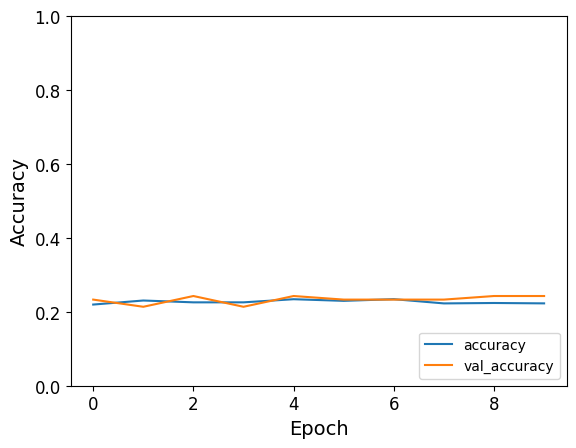

In [8]:
num_classes=10
epochs=10
batch_size=64
kernel=(3, 3)
strides=(2, 2)
input_shape=x_train_reshaped.shape[1:]
model = create_cnn(input_shape=input_shape, num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.1)
history = model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, 
                         validation_data=(x_test_reshaped, y_test))

test_loss, test_acc = model.evaluate(x_test_reshaped,  y_test, verbose=2)
print(f'Loss: {test_loss}, Accuracy: {test_acc}')
plotHistory(history)

In [9]:
model = create_cnn(input_shape=input_shape, num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.01)
history = model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test_reshaped, y_test))

test_loss, test_acc = model.evaluate(x_test_reshaped,  y_test, verbose=2)
print(f'Loss: {test_loss}, Accuracy: {test_acc}')
plotHistory(history)

Epoch 1/10
152/152 [==============================] - 2s 11ms/step - loss: 1.4031 - accuracy: 0.4795 - val_loss: 0.9558 - val_accuracy: 0.6806
Epoch 2/10
152/152 [==============================] - 1s 9ms/step - loss: 0.4373 - accuracy: 0.8544 - val_loss: 0.4599 - val_accuracy: 0.8294
Epoch 3/10
152/152 [==============================] - 2s 12ms/step - loss: 0.2386 - accuracy: 0.9198 - val_loss: 0.3205 - val_accuracy: 0.8909
Epoch 4/10
152/152 [==============================] - 2s 10ms/step - loss: 0.1607 - accuracy: 0.9456 - val_loss: 0.3886 - val_accuracy: 0.8689
Epoch 5/10
120/152 [======================>.......] - ETA: 0s - loss: 0.1275 - accuracy: 0.9556

KeyboardInterrupt: 

Epoch 1/10
152/152 [==============================] - 6s 23ms/step - loss: 1.5488 - accuracy: 0.4285 - val_loss: 1.3220 - val_accuracy: 0.4935
Epoch 2/10
152/152 [==============================] - 2s 12ms/step - loss: 0.8946 - accuracy: 0.6971 - val_loss: 0.8892 - val_accuracy: 0.7223
Epoch 3/10
152/152 [==============================] - 2s 11ms/step - loss: 0.5484 - accuracy: 0.8438 - val_loss: 0.7287 - val_accuracy: 0.7498
Epoch 4/10
152/152 [==============================] - 2s 14ms/step - loss: 0.3673 - accuracy: 0.8991 - val_loss: 0.5325 - val_accuracy: 0.8437
Epoch 5/10
152/152 [==============================] - 3s 17ms/step - loss: 0.2640 - accuracy: 0.9329 - val_loss: 0.4893 - val_accuracy: 0.8427
Epoch 6/10
152/152 [==============================] - 3s 17ms/step - loss: 0.2100 - accuracy: 0.9466 - val_loss: 0.4279 - val_accuracy: 0.8615
Epoch 7/10
152/152 [==============================] - 3s 18ms/step - loss: 0.1658 - accuracy: 0.9595 - val_loss: 0.3875 - val_accuracy: 0.8744

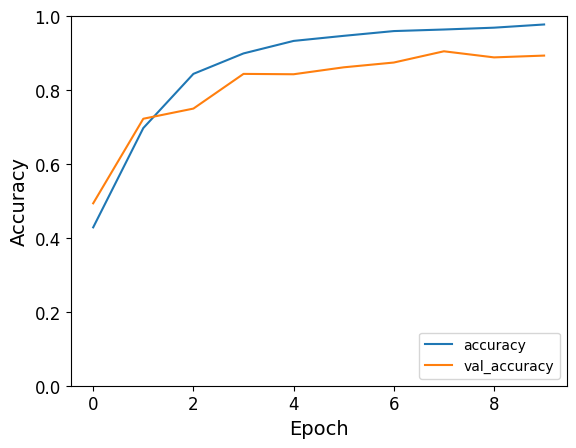

In [ ]:
model = create_cnn(input_shape=input_shape, num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.001)
history = model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test_reshaped, y_test))

test_loss, test_acc = model.evaluate(x_test_reshaped,  y_test, verbose=2)
print(f'Loss: {test_loss}, Accuracy: {test_acc}')
plotHistory(history)

Epoch 1/10
152/152 [==============================] - 6s 32ms/step - loss: 1.9256 - accuracy: 0.2989 - val_loss: 1.8888 - val_accuracy: 0.3049
Epoch 2/10
152/152 [==============================] - 4s 26ms/step - loss: 1.7427 - accuracy: 0.3973 - val_loss: 1.7682 - val_accuracy: 0.3828
Epoch 3/10
152/152 [==============================] - 4s 26ms/step - loss: 1.6037 - accuracy: 0.4059 - val_loss: 1.6678 - val_accuracy: 0.3896
Epoch 4/10
152/152 [==============================] - 4s 27ms/step - loss: 1.4792 - accuracy: 0.4481 - val_loss: 1.6036 - val_accuracy: 0.4045
Epoch 5/10
152/152 [==============================] - 4s 29ms/step - loss: 1.3637 - accuracy: 0.5134 - val_loss: 1.5138 - val_accuracy: 0.4566
Epoch 6/10
152/152 [==============================] - 5s 31ms/step - loss: 1.2595 - accuracy: 0.5785 - val_loss: 1.4522 - val_accuracy: 0.5227
Epoch 7/10
152/152 [==============================] - 5s 30ms/step - loss: 1.1631 - accuracy: 0.6216 - val_loss: 1.3715 - val_accuracy: 0.5537

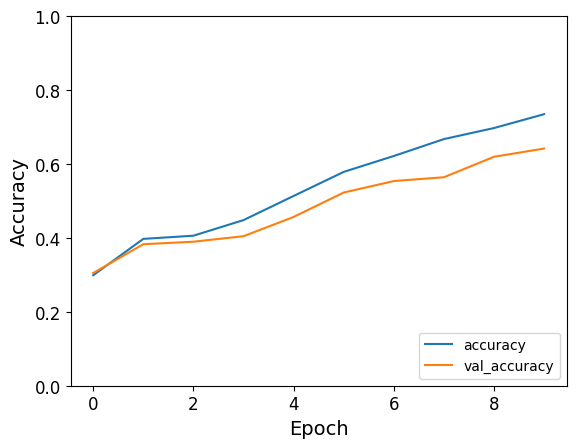

In [ ]:
model = create_cnn(input_shape=input_shape, num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.0001)
history = model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test_reshaped, y_test))

test_loss, test_acc = model.evaluate(x_test_reshaped,  y_test, verbose=2)
print(f'Loss: {test_loss}, Accuracy: {test_acc}')
plotHistory(history)

Epoch 1/10
152/152 [==============================] - 7s 31ms/step - loss: 2.2027 - accuracy: 0.2092 - val_loss: 2.1361 - val_accuracy: 0.2450
Epoch 2/10
152/152 [==============================] - 4s 27ms/step - loss: 2.0567 - accuracy: 0.2433 - val_loss: 2.0316 - val_accuracy: 0.2424
Epoch 3/10
152/152 [==============================] - 4s 27ms/step - loss: 1.9721 - accuracy: 0.2656 - val_loss: 1.9729 - val_accuracy: 0.2638
Epoch 4/10
152/152 [==============================] - 4s 27ms/step - loss: 1.9153 - accuracy: 0.2999 - val_loss: 1.9383 - val_accuracy: 0.2786
Epoch 5/10
152/152 [==============================] - 4s 28ms/step - loss: 1.8802 - accuracy: 0.3138 - val_loss: 1.9149 - val_accuracy: 0.3010
Epoch 6/10
152/152 [==============================] - 4s 25ms/step - loss: 1.8538 - accuracy: 0.3258 - val_loss: 1.8961 - val_accuracy: 0.3230
Epoch 7/10
152/152 [==============================] - 4s 26ms/step - loss: 1.8312 - accuracy: 0.3506 - val_loss: 1.8795 - val_accuracy: 0.3786

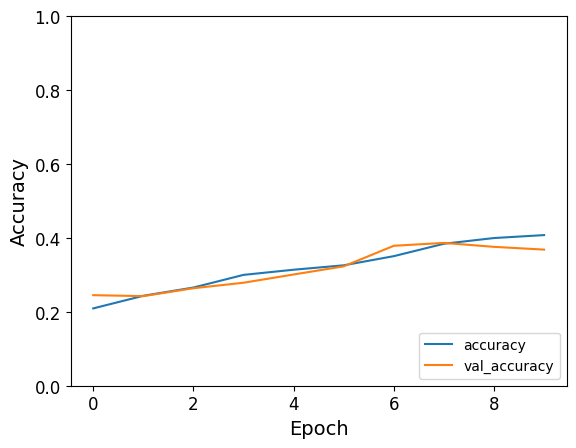

In [ ]:
model = create_cnn(input_shape=input_shape, num_classes=num_classes, kernel=kernel,strides=strides,learning_rate=0.00001)
history = model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test_reshaped, y_test))

test_loss, test_acc = model.evaluate(x_test_reshaped,  y_test, verbose=2)
print(f'Loss: {test_loss}, Accuracy: {test_acc}')
plotHistory(history)

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


https://adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html#scikeras.wrappers.KerasClassifier


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

input_shape = x_train_reshaped.shape[1:]

param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [5, 7],
    'learning_rate': [0.01],
    'kernel': [(3, 3), (5, 5)],
    'strides': [(1, 1), (2, 2)],
    'filters': [32, 64, 128],
    'dense_units': [64, 128],
}

model = KerasClassifier(build_fn=create_cnn, verbose=2,dense_units=64,filters=32,kernel=(3, 3),learning_rate=0.01,strides=(1, 1))
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
grid_result = grid.fit(x_train_reshaped, y_train)

NameError: name 'x_train_reshaped' is not defined